# 🖊️ Pen Plotter — Clean Quickstart (GRBL, Safe)

A modular, beginner-friendly workflow for controlling a GRBL-based pen plotter with Python.

- Connect and configure your device
- Manually home the arm (move to Arduino for origin)
- Calibrate pen contact
- Plot a custom SVG
- Safely close the connection

All logic is organized in `penplot_helper.py`. Follow the steps below!

## 🏠 Manual Homing

Move the pen arm gently towards the Arduino to set the origin (x=0, y=0).
This step ensures accurate positioning before plotting.

## ⚙️ Initialization

Set up your pen plotter and connect to GRBL below.
Make sure your device is on the correct port.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from penplot_helper import Config, GRBL
import numpy as np
import matplotlib.pyplot as plt

# Connect
cfg = Config(
    port="/dev/tty.usbserial-A50285BI",
    x_max=300.0, y_max=245.0,
    s_down=90, s_up=40,
)
grbl = GRBL(cfg).connect()

# Warm up status and print it
grbl.ensure_wpos()
grbl.status()


{'raw': '<Idle|MPos:0.000,0.000,0.000|Bf:15,128|FS:0,0|Ov:100,100,100>',
 'state': 'Idle',
 'wpos': (0.0, 0.0, 0.0)}

## Test rectangle sweep to set paper size

In [5]:
# Define bed and do a quick perimeter check (pen up)
grbl.pen_up(step=0.1)
#grbl.set_bed(300.0, 225.0)
grbl.sweep_rect(cfg.x_max, cfg.y_max)

# Go to center (absolute work coords)
grbl.goto_abs(cfg.x_max/2.0, cfg.y_max/2.0)
grbl.goto_abs(  0.0,   0.0)

grbl.pen_down(step=0.1)

Goto absolute: (150.000, 122.500)
Goto absolute: (0.000, 0.000)


In [6]:
grbl.status()

{'raw': '<Idle|MPos:0.000,0.000,0.000|Bf:15,128|FS:0,90|WCO:0.000,0.000,0.000>',
 'state': 'Idle',
 'wpos': (0.0, 0.0, 0.0)}

## 📐 Select Project Area

Interactively choose the bottom left and top right corners of your project area. The surface compensation will use these bounds for calibration.

In [6]:
from penplot_widgets import show_area_and_compensation_widget
get_area_and_comp = show_area_and_compensation_widget(grbl)  # Interactively set area and compensation (motor updates on slider change)

## Setup conveniences

In [179]:
import penplot_widgets as ppw
key   = (round(cfg.x_max, 3), round(cfg.y_max, 3))
saved = getattr(ppw, "_PPW_STATE", {}).get(key, None)
saved


{'corners': {'BL': {'x': 26.352524574408235,
   'y': 6.210494093613239,
   'h': 0.32},
  'BR': {'x': 233.3585255745749, 'y': 6.210494093613239, 'h': 0.32},
  'TL': {'x': 26.352524574408235, 'y': 161.14484857939004, 'h': 0.49},
  'TR': {'x': 233.3585255745749, 'y': 161.14484857939004, 'h': 0.53}},
 'pots': []}

### Test Pattern

In [8]:
from pattern import Pattern, Renderer, Polyline, Circle, Line
import math, random


# Minimal pattern: 2 circles + 1 line + 1 polyline
p = Pattern()
p.add(
    Circle((30.0, 30.0), 14.0, pen_pressure=-0.1, start_deg=0,   sweep_deg=360, feed_draw=5000, pen_id=0),
    Circle((70.0, 50.0), 18.0, pen_pressure=-0.05, start_deg=180, sweep_deg=180, feed_draw=5000, pen_id=1),  
    Line((20.0, 80.0), (100.0, 80.0), pen_pressure=-0.05, feed_draw=10000),
    Polyline([(20.0, 20.0), (50.0, 25.0), (80.0, 22.0)], pen_pressure=-0.0, feed_draw=1000),
)

# Renderer (your params)
r = Renderer(grbl,
             z_mode="centroid",
             z_threshold=0.1,
             settle_down_s=0.04,
             settle_up_s=0.04,
             z_step=0.02,
             z_step_delay=0.00,
             flush_every=300,
             feed_travel=15000,
             lift_delta=0.8)

r.plot(p)

# r.run(p,
#       pen_filter = [0,1], 
#       start_xy=(0.0, 0.0),  # for nn optimization
#       optimize='nn',
#       combine={'join_tol_mm': 0.1},
#       resample={'max_dev_mm': 0.1, 'max_seg_mm': None})


### Truchet tiles

In [6]:
from pattern import Pattern, Renderer, Polyline, Circle, Line
import random, math

def offsets(tile, bands, margin, bias_p=2.0):
    if bands <= 0: return []
    if bands == 1: return [tile*0.5]
    c = (bands-1)/2
    gaps = [1/((1+abs(i+0.5-c))**bias_p) for i in range(bands-1)]
    span = tile-2*margin
    s, pos = margin, [margin]
    k = span/sum(gaps)
    for g in gaps:
        s += g*k
        pos.append(s)
    return [round(max(margin, min(tile-margin, x)), 6) for x in pos]

def pen_for_band(i, pen_main, pen_alt, highlight_band=None):
    return pen_alt if (highlight_band is not None and i == highlight_band) else pen_main

def add_vertical_bundle(p, x0, y0, T, pos, feed, press, pen_main, pen_alt, highlight_band):
    for i,x in enumerate(pos):
        p.add(Line((x0+x,y0),(x0+x,y0+T), pen_id=pen_for_band(i,pen_main,pen_alt,highlight_band),
                   pen_pressure=press, feed_draw=feed))

def add_horizontal_bundle_cut_block(p, x0, y0, T, pos_y, bundle_xs, feed, press, pen_main, pen_alt, highlight_band, margin=0.0):
    # cut from first to last vertical across the whole bundle (plus optional margin)
    if not bundle_xs: 
        xs = (x0, x0+T)
    else:
        xs = (x0+min(bundle_xs)-margin, x0+max(bundle_xs)+margin)
    for i,y in enumerate(pos_y):
        yA = y0+y
        leftA, rightA = x0, x0+T
        # left segment
        if xs[0]-leftA > 1e-3:
            p.add(Line((leftA,yA),(xs[0],yA),
                       pen_id=pen_for_band(i,pen_main,pen_alt,highlight_band),
                       pen_pressure=press, feed_draw=feed))
        # right segment
        if rightA-xs[1] > 1e-3:
            p.add(Line((xs[1],yA),(rightA,yA),
                       pen_id=pen_for_band(i,pen_main,pen_alt,highlight_band),
                       pen_pressure=press, feed_draw=feed))

def add_curves_both_with_priority(p, x0, y0, T, pos, feed, press, pen_hi, pen_lo, highlight_band,
                                  hi_family="NE_SW", cut_window=(30.0,60.0)):
    # helper to draw quarter arcs, optionally cut by angular window (degrees) relative to the quarter start
    def qarc(cx, cy, start_deg, r, pen, cut=None):
        if cut is None:
            p.add(Circle((cx,cy), r, start_deg=start_deg, sweep_deg=90, pen_id=pen,
                         pen_pressure=press, feed_draw=feed))
        else:
            a0,a1 = start_deg+cut[0], start_deg+cut[1]
            if a0-start_deg > 0.1:
                p.add(Circle((cx,cy), r, start_deg=start_deg, sweep_deg=a0-start_deg, pen_id=pen,
                             pen_pressure=press, feed_draw=feed))
            if start_deg+90 - a1 > 0.1:
                p.add(Circle((cx,cy), r, start_deg=a1, sweep_deg=start_deg+90-a1, pen_id=pen,
                             pen_pressure=press, feed_draw=feed))
    # map families to corners and starts
    fams = {
        "NE_SW": [((x0+T,y0+T),180), ((x0,y0),0)],   # NE and SW
        "NW_SE": [((x0,y0+T),270),   ((x0+T,y0),90)] # NW and SE
    }
    hi, lo = hi_family, ("NW_SE" if hi_family=="NE_SW" else "NE_SW")
    # draw high family full arcs
    for i,r in enumerate(pos):
        if r <= 0 or r > T: continue
        pen_i = pen_for_band(i, pen_hi, pen_lo, highlight_band)
        for (cx,cy), s in fams[hi]:
            qarc(cx,cy,s,r,pen_i,None)
    # draw low family cut by shared window
    for i,r in enumerate(pos):
        if r <= 0 or r > T: continue
        pen_i = pen_for_band(i, pen_lo, pen_hi, highlight_band)
        for (cx,cy), s in fams[lo]:
            qarc(cx,cy,s,r,pen_i,cut_window)

def make_tiles_rect(origin=(0.0,0.0), size_x=180.0, size_y=120.0, tile=16.0,
                    bands=5, margin=1.6, bias_p=2.0, seed=12345,
                    feed_draw=2400, pen_pressure=-0.05,
                    pen_ids=(0,1), highlight_band=None,
                    straight_ratio=0.1, cut_margin=0.0,
                    curve_priority="NE_SW", curve_cut_window=(30.0,60.0)):
    rng = random.Random(seed)
    nx, ny = max(int(size_x//tile),1), max(int(size_y//tile),1)
    ox, oy = origin
    pos = offsets(tile, bands, margin, bias_p)
    p = Pattern()
    penA, penB = pen_ids
    for j in range(ny):
        for i in range(nx):
            x0, y0 = ox+i*tile, oy+j*tile
            if rng.random() < straight_ratio:
                # STRAIGHT: vertical bundle (full), horizontals cut as one block spanning first..last vertical
                add_vertical_bundle(p, x0, y0, tile, pos, feed_draw, pen_pressure, penA, penB, highlight_band)
                add_horizontal_bundle_cut_block(p, x0, y0, tile, pos, pos, feed_draw, pen_pressure,
                                                penB, penA, highlight_band, margin=cut_margin)
            else:
                # CURVES_BOTH: both families present; low family cut by one wide window so crossings are entirely removed
                add_curves_both_with_priority(p, x0, y0, tile, pos, feed_draw, pen_pressure,
                                              penA, penB, highlight_band, hi_family=curve_priority,
                                              cut_window=curve_cut_window)
    return p


art = make_tiles_rect(
    origin=(50.0,50.0), size_x=100.0, size_y=100.0, tile=12.5,
    bands=3, margin=1.5, bias_p=2.2, seed=20250923,
    feed_draw=2000, pen_pressure=-0.06,
    pen_ids=(1,2),            # two colors
    highlight_band=2,         # 0-based: band index 2 (the 3rd line) always uses pen 2
    straight_ratio=0.4,       # mix straight vs curves
    cut_margin=0.4,           # extend the removed block slightly beyond first/last crossing
    curve_priority="NE_SW",
    curve_cut_window=(28.0,62.0)  # wide removal across the entire crossing region
)

r = Renderer(grbl, z_mode="centroid", z_threshold=0.1,
             settle_down_s=0.04, settle_up_s=0.04,
             z_step=0.02, z_step_delay=0.00,
             flush_every=400, feed_travel=5000, lift_delta=0.4)
r.plot(art)


In [ ]:
# r.run(art,
#       pen_filter = [1], 
#       start_xy=(0.0, 0.0),  # for nn optimization
#       optimize='nn',
#       combine={'join_tol_mm': 0.1},
#       resample={'max_dev_mm': 0.1, 'max_seg_mm': None})

### Plantes horizontal lines

In [8]:
# --- Gravity-flow “scanlines”: 120 horizontal rays entering from the left, deflected by hard-coded planets ---
# Updated for the new API: z/settling behavior lives on the Renderer (not per-line).
# Prereqs: cfg, grbl, Pattern/Polyline/Renderer, and a saved rectangle via the widget.

import math, numpy as np, penplot_widgets as ppw
from pattern import Pattern, Polyline, Renderer

# 1) Load calibrated rectangle (+ program Z surface map)
key   = (round(cfg.x_max, 3), round(cfg.y_max, 3))
state = (getattr(ppw, "_PPW_STATE", {}) or {}).get(key) or {}
BL = state.get("corners", {}).get("BL"); TR = state.get("corners", {}).get("TR")
assert BL and TR, "Calibration rectangle not found. Open the widget and Save Settings."
x0, y0, x1, y1 = float(BL["x"]), float(BL["y"]), float(TR["x"]), float(TR["y"])

# 2) Parameters
W, H = (x1 - x0), (y1 - y0)
circle_samples     = 120

n_rays             = 160         # number of horizontal rays
launch_inset_mm    = 0.0         # inset from left edge
y_inset_mm         = 0.0         # inset from top/bottom for seeding
start_jitter_mm    = 0.0         # optional vertical jitter (0 = evenly spaced)

# Integration (smooth arclength + ramped speed)
step_mm     = 0.45
substeps    = 4
v0_mm       = 0.1
cruise_mm   = 0.1
ramp_steps  = 50
max_steps   = 1200

soft_mm     = 0.0#2.0
G_eff       = 0.002
accel_clip  = 100000
hit_margin_mm = 0.0

# Motion / pen (per-path feed stays on the polyline; Z strategy lives on Renderer)
feed_draw   = 1500

# 3) Hard-coded planets (fx, fy, fr) w.r.t. the calibrated rectangle
#    fx, fy in [0..1], fr is radius as a fraction of min(W,H).
#    All planets are placed on the RIGHT HALF (fx >= 0.55). Edit this list as you like.
PLANETS_FRAC = [
    (0.58, 0.02, 0.035),
    (0.40, 0.35, 0.020),
    (0.69, 0.24, 0.012),
    (0.73, 0.12, 0.028),
    (0.77, 0.30, 0.045),
    (0.82, 0.18, 0.018),
    (0.86, 0.42, 0.024),
    (0.90, 0.25, 0.010),
    (0.93, 0.12, 0.016),
    (0.42, 0.60, 0.030),
    (0.66, 0.76, 0.020),
    (0.74, 0.68, 0.014),
    (0.80, 0.95, 0.038),
    (0.88, 0.70, 0.022),
    (0.94, 0.95, 0.012),
]

# 4) Convert planets to absolute coords (cx, cy, r, mass)
R0 = min(W, H)
planets = []
for fx, fy, fr in PLANETS_FRAC:
    cx = x0 + fx * W
    cy = y0 + fy * H
    r  = fr * R0
    m  = r * r
    planets.append((cx, cy, r, m))

# 5) Utilities
def circle_poly(cx, cy, r, n=circle_samples):
    return [(cx + r*math.cos(2*math.pi*i/n), cy + r*math.sin(2*math.pi*i/n)) for i in range(n+1)]

def gravity_accel(x, y):
    ax = ay = 0.0
    for (cx, cy, r, m) in planets:
        dx, dy = (cx - x), (cy - y)
        d2 = dx*dx + dy*dy + soft_mm*soft_mm
        inv_d = 1.0 / math.sqrt(d2)
        inv_d3 = inv_d * inv_d * inv_d
        a = G_eff * m * inv_d3
        ax += a * dx
        ay += a * dy
    mag = math.hypot(ax, ay)
    if mag > accel_clip:
        ax *= accel_clip / mag
        ay *= accel_clip / mag
    return ax, ay

def inside_rect(x, y): return (x0 <= x <= x1) and (y0 <= y <= y1)
def hits_planet(x, y):
    for (cx, cy, r, _) in planets:
        if math.hypot(x - cx, y - cy) <= (r + hit_margin_mm):
            return True
    return False

# 6) Build pattern (planet outlines + rays)
pat = Pattern()

# Planet outlines (optional; comment out if you don't want circles drawn)
for (cx, cy, r, _) in planets:
    pat.add(Polyline(pts=circle_poly(cx, cy, r), pen_id=0, feed_draw=1000))

# Launch horizontal rays from left edge
x_start = x0 + launch_inset_mm
ys = np.linspace(y0 + y_inset_mm, y1 - y_inset_mm, n_rays)
if start_jitter_mm > 0:
    ys = np.array([float(y + np.random.uniform(-start_jitter_mm, start_jitter_mm)) for y in ys])

for y_start in ys:
    if hits_planet(x_start, y_start):
        continue

    x, y = x_start, y_start
    vx, vy = v0_mm, 0.0
    ax, ay = gravity_accel(x, y)
    pts = [(x, y)]

    for step in range(max_steps):
        v_target = v0_mm + (cruise_mm - v0_mm) * min(1.0, step / float(ramp_steps))
        ds  = step_mm
        dsm = ds / float(substeps)
        broke = False

        for _ in range(substeps):
            dt = dsm / max(1e-9, v_target)

            # half-kick
            vx += 0.5 * ax * dt
            vy += 0.5 * ay * dt
            # enforce target speed
            vm = math.hypot(vx, vy) or 1.0
            vx *= (v_target / vm)
            vy *= (v_target / vm)
            # drift
            x += vx * dt
            y += vy * dt

            if (not inside_rect(x, y)) or hits_planet(x, y):
                broke = True
                break

            # update accel + half-kick
            ax, ay = gravity_accel(x, y)
            vx += 0.5 * ax * dt
            vy += 0.5 * ay * dt

        if broke:
            break
        pts.append((x, y))

    if len(pts) >= 2:
        pat.add(Polyline(pts=pts, pen_id=0, feed_draw=feed_draw))

# 7) Render (all z/settle behavior lives on the Renderer)
r = Renderer(
    grbl,
    z_mode="start",
    z_threshold=0.0,
    settle_down_s=0.15,
    settle_up_s=0.15,
    z_step=0.02,
    z_step_delay=0.00,
    flush_every=400,
    feed_travel=3000,
    lift_delta=0.5,
)
r.plot(pat)


In [9]:
# r.run(pat,
#       pen_filter = [0], 
#       start_xy=(0.0, 0.0),  # for nn optimization
#       #optimize='nn',
#       #combine={'join_tol_mm': 0.1},
#       resample={'max_dev_mm': 0.1, 'max_seg_mm': None})

### Height map

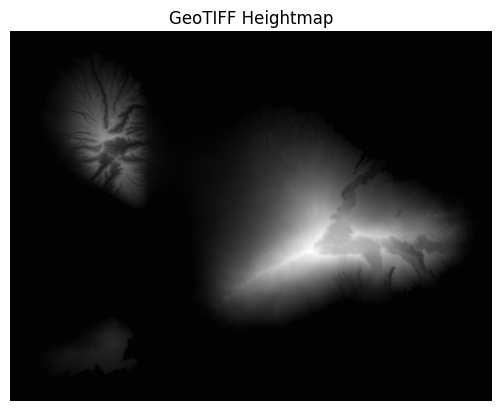

In [69]:
import rasterio

# Yes, using a GeoTIFF would help! GeoTIFFs are standard raster formats for geospatial data.
# They include metadata (like projection, georeferencing, and shape) and are easy to read with libraries like rasterio.

# Example: Reading a GeoTIFF with rasterio
import matplotlib.pyplot as plt

filename = "opentopo_maui.tif"  # Replace with your GeoTIFF file path
with rasterio.open(filename) as src:
    img = src.read(1)  # Read the first band
    plt.imshow(img, cmap='gray')
    plt.title("GeoTIFF Heightmap")
    plt.axis('off')
    plt.gca().set_aspect('1.0', adjustable='box')
    plt.show()

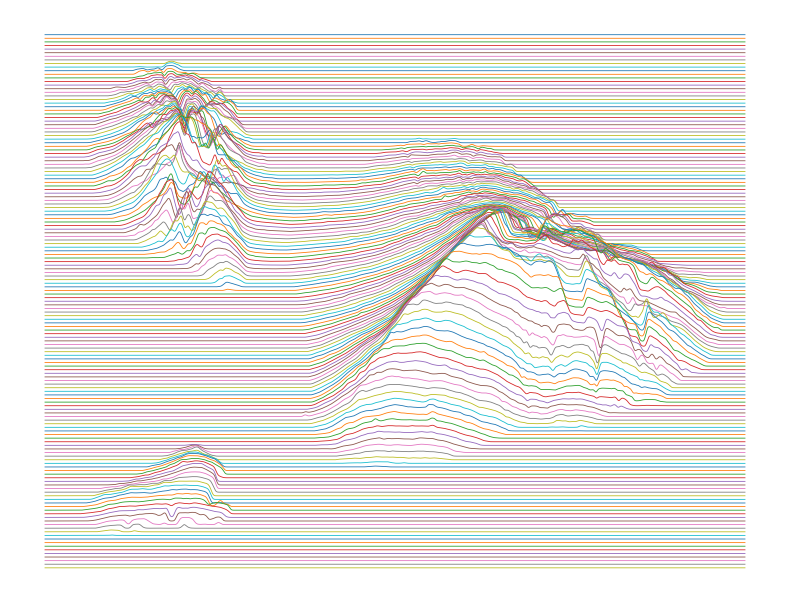

Saved SVG to: heightline_art.svg


In [80]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Parameters
# ----------------------------
tif_path = "opentopo_maui.tif"

# Optional crop in [row_min:row_max, col_min:col_max] (set to None to disable)
#crop = (slice(1800, 3200), slice(1300, 3600))   # matches your example
# crop = None

n_lines = 150                 # number of horizontal lines
amplitude_px = 500.0           # vertical modulation amplitude in pixels (try 20..80)
occlusion_gap = 0.0           # extra gap in pixels to ensure a sliver of space (try 0.5..1.0)
smooth_sigma = 5          # gaussian smoothing of height map in pixels (use 0 for none)
downsample_x = 1              # sample every k columns to reduce output size (>=1)
svg_out = "heightline_art.svg"  # set to None to skip writing SVG

# ----------------------------
# Helpers
# ----------------------------
def gaussian_blur(img, sigma):
    if sigma <= 0:
        return img
    # simple separable gaussian using FFT or scipy would be nicer, but avoid extra deps:
    # quick-and-dirty: repeated 1D conv with small kernel
    r = max(1, int(3*sigma))
    x = np.arange(-r, r+1, dtype=float)
    k = np.exp(-(x**2)/(2*sigma*sigma))
    k /= k.sum()
    # convolve rows then columns
    pad = ((0,0),(r,r))
    tmp = np.pad(img, pad, mode="edge")
    tmp = np.apply_along_axis(lambda v: np.convolve(v, k, mode="same"), 1, tmp)
    tmp = tmp[:, r:-r]
    pad = ((r,r),(0,0))
    tmp = np.pad(tmp, pad, mode="edge")
    tmp = np.apply_along_axis(lambda v: np.convolve(v, k, mode="same"), 0, tmp)
    tmp = tmp[r:-r, :]
    return tmp

def normalize01(arr):
    a = np.nanmin(arr)
    b = np.nanmax(arr)
    if b <= a + 1e-12:
        return np.zeros_like(arr)
    return (arr - a) / (b - a)

def poly_segments_from_visibility(x, y, visible_mask):
    """Split a polyline into visible segments based on a boolean mask."""
    segs = []
    in_seg = False
    for i in range(len(x)):
        vis = bool(visible_mask[i])
        if vis and not in_seg:
            # start new segment
            segs.append([ (x[i], y[i]) ])
            in_seg = True
        elif vis and in_seg:
            segs[-1].append((x[i], y[i]))
        elif (not vis) and in_seg:
            in_seg = False
    return segs

def write_svg(polylines, W, H, path):
    # polylines: list of list of (x,y)
    # W,H: canvas size in pixels
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(f'<svg xmlns="http://www.w3.org/2000/svg" width="{W}" height="{H}" viewBox="0 0 {W} {H}">\n')
        f.write('<g fill="none" stroke="black" stroke-width="1">\n')
        for seg in polylines:
            if len(seg) < 2:
                continue
            d = "M " + " L ".join(f"{p[0]:.2f} {p[1]:.2f}" for p in seg)
            f.write(f'  <path d="{d}"/>\n')
        f.write('</g>\n</svg>\n')

# ----------------------------
# Load height map
# ----------------------------
with rasterio.open(tif_path) as src:
    img = src.read(1).astype(float)

# optional smoothing and normalization
img = gaussian_blur(img, smooth_sigma)
hmap = normalize01(img)

H, W = hmap.shape
xs = np.arange(0, W, downsample_x).astype(float)

# ----------------------------
# Build lines with occlusion
# ----------------------------
# Base y positions (top to bottom, equally spaced)
base_ys = np.linspace(0, H-1, n_lines)

# Current silhouette = y of the uppermost visible content at each x (start with +inf so first line is always visible)
silhouette = np.full_like(xs, np.inf, dtype=float)

all_visible_segments = []   # for preview
svg_segments = []           # for writing

for i, y0 in enumerate(base_ys):
    # Sample the height values along a horizontal slice nearest to y0
    row = int(round(y0))
    row = max(0, min(H-1, row))
    h_row = hmap[row, :][::downsample_x]

    # Modulate upward by height (smaller y moves upward on the page)
    y_line = y0 - amplitude_px * h_row

    # Visibility test: keep only points that are NOT in front of lines above.
    # Interpretation: lines closer to the top are "in front".
    # If the new line rises above the existing silhouette (y_new < silhouette), it is behind and must be hidden.
    # So visible when y_new >= silhouette + occlusion_gap.
    visible = y_line >= (silhouette + occlusion_gap)

    # Split into continuous visible segments
    segments = poly_segments_from_visibility(xs, y_line, visible)
    all_visible_segments.extend(segments)
    svg_segments.extend(segments)

    # Update silhouette only where this line becomes the new upper bound.
    # The visible parts that are still above anyone else should not reduce the current min,
    # because smaller y is visually in front. We want silhouette(x) = min of all drawn lines’ y.
    # However, our visibility keeps y_line >= silhouette, so min remains silhouette.
    # For completeness, in case parameters allow crossing, clamp to the smaller value.
    silhouette = np.minimum(silhouette, y_line)

# ----------------------------
# Preview
# ----------------------------
plt.figure(figsize=(8, 8 * H / W))
for seg in all_visible_segments:
    if len(seg) < 2:
        continue
    sx = [p[0] for p in seg]
    sy = [p[1] for p in seg]
    plt.plot(sx, sy, linewidth=0.6)
plt.gca().invert_yaxis()   # y down increases visually, invert for natural “up”
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

# ----------------------------
# SVG export
# ----------------------------
if svg_out:
    write_svg(svg_segments, W, H, svg_out)
    print(f"Saved SVG to: {svg_out}")



# # Assuming calibrated rectangle [x0,y0]..[x1,y1] and your grbl/Renderer objects exist
# from pattern import Pattern, Polyline, Renderer

# def to_mm(px_x, px_y, x0, y0, x1, y1, W, H):
#     xm = x0 + (px_x / (W - 1)) * (x1 - x0)
#     ym = y0 + (px_y / (H - 1)) * (y1 - y0)
#     return xm, ym

# pat = Pattern()
# for seg in svg_segments:
#     pts = [to_mm(x, y, x0, y0, x1, y1, W, H) for (x, y) in seg]
#     if len(pts) >= 2:
#         pat.add(Polyline(pts=pts, pen_id=0, feed_draw=1500))

# r = Renderer(grbl, z_mode="start", settle_down_s=0.15, settle_up_s=0.15,
#              z_step=0.02, flush_every=400, feed_travel=3000, lift_delta=0.5)
# r.plot(pat)







### New

In [182]:
# Radial rings with noise, smoothing, optional occlusion, clipping to drawing plane,
# and a per ring shift for a drifting effect.
# Prereqs in your environment: cfg, grbl, penplot_widgets as ppw, Pattern, Polyline, Renderer,
# and a saved rectangle in the widget.

import math, numpy as np, penplot_widgets as ppw
from pattern import Pattern, Polyline, Renderer

# 1) Calibrated rectangle
key   = (round(cfg.x_max, 3), round(cfg.y_max, 3))
state = (getattr(ppw, "_PPW_STATE", {}) or {}).get(key) or {}
BL = state.get("corners", {}).get("BL"); TR = state.get("corners", {}).get("TR")
assert BL and TR, "Calibration rectangle not found. Open the widget and Save Settings."
x0, y0, x1, y1 = float(BL["x"]), float(BL["y"]), float(TR["x"]), float(TR["y"])
W_mm, H_mm = (x1 - x0), (y1 - y0)
C_mm = min(W_mm, H_mm)

# 2) Parameters
n_rings             = 50
samples             = 3000
margin_mm           = 0.0
r0_mm               = 0.03 * C_mm
ring_spacing_mm     = 1.5#1.8*   (0.5*C_mm - margin_mm - r0_mm) / (50 + 1)
cx0, cy0            = x0 + 0.40*W_mm, y0 + 0.45*H_mm

# Noise along angle
noise_band_pts      = 25
noise_start         = 0.0
noise_growth        = 0.03
noise_clip          = 10.0

# Smoothing
smooth_sigma_start  = 2.0
smooth_sigma_growth = 0.0
smooth_repeats      = 4

# Extras
turn_per_ring       = 1/360 * 2*np.pi   # radians of angular turn per ring
shift_per_ring_mm   = (0.5, 0.25)  # dx, dy drift per ring in mm

min_gap_mm          = 1.5     # minimum outward gap between rings

# Visibility options
use_occlusion       = False   # set True to enable light based occlusion
light_deg           = 0#-35.0
occlusion_gap_mm    = 0.0

# Plane clipping
clip_to_plane       = True    # remove segments that leave the drawing rectangle

feed_draw           = 1500
pen_pressure       = -0.15

# 3) Helpers
def gaussian_kernel(radius):
    x = np.arange(-radius, radius + 1, dtype=float)
    sigma = max(1e-6, radius / 3.0)
    k = np.exp(-(x*x) / (2.0*sigma*sigma))
    k /= k.sum()
    return k

def blur_1d(arr, radius, wrap=False):
    if radius <= 0:
        return arr
    k = gaussian_kernel(int(radius))
    pad = int(radius)
    if wrap:
        a = np.concatenate([arr[-pad:], arr, arr[:pad]])
        b = np.convolve(a, k, mode="same")
        return b[pad:-pad]
    else:
        a = np.pad(arr, pad_width=pad, mode="edge")
        b = np.convolve(a, k, mode="same")
        return b[pad:-pad]

def band_limited_noise(n, band_pts):
    w = np.random.randn(n)
    return blur_1d(w, band_pts, wrap=True)

def split_visible_segments(xs, ys, visible_mask):
    segs = []
    n = len(xs)
    i = 0
    while i < n:
        if not visible_mask[i]:
            i += 1
            continue
        j = i + 1
        while j < n and visible_mask[j]:
            j += 1
        segs.append(list(zip(xs[i:j], ys[i:j])))
        i = j
    return segs

def inside_rect_mask(xs, ys, x0, y0, x1, y1):
    return (xs >= x0) & (xs <= x1) & (ys >= y0) & (ys <= y1)

# 4) Build rings in polar, then map to mm with drift and turn
theta = np.linspace(0.0, 2.0*math.pi, samples, endpoint=False)


r_prev = np.full_like(theta, r0_mm)
rings = []

for i in range(n_rings):
    if i == 0:
        r = r_prev.copy()
    else:
        r = r_prev + ring_spacing_mm
        amp = min(noise_clip, noise_start + i*noise_growth)
        n = band_limited_noise(samples, noise_band_pts)
        n = n / (np.std(n) + 1e-12)
        phase = i * turn_per_ring
        idx = (np.arange(samples) + phase * samples / (2.0*math.pi)) % samples
        n_swirl = np.interp(idx, np.arange(samples), n)
        r = r + amp * n_swirl
        sigma = smooth_sigma_start + i * smooth_sigma_growth
        for _ in range(max(1, int(smooth_repeats))):
            r = blur_1d(r, sigma, wrap=True)
        r = np.maximum(r, r_prev + min_gap_mm)

    # Per ring drift of the center
    cx = cx0 + i * shift_per_ring_mm[0]
    cy = cy0 + i * shift_per_ring_mm[1]

    # Apply the same phase turn to geometry as well
    phi = theta + i * turn_per_ring

    x = cx + r * np.cos(phi)
    y = cy + r * np.sin(phi)

    rings.append((x, y))
    r_prev = r

# 5) Visibility and clipping
pat = Pattern()

if use_occlusion:
    ang = math.radians(light_deg)
    Lx, Ly = math.cos(ang), math.sin(ang)     # light direction
    Tx, Ty = -Ly, Lx                          # perpendicular axis

    rect_pts = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]], dtype=float)
    t_rect = rect_pts @ np.array([Tx, Ty])
    t_min, t_max = float(t_rect.min()), float(t_rect.max())
    t_bins = samples
    t_edges = np.linspace(t_min, t_max, t_bins + 1)
    silhouette = np.full(t_bins, -np.inf, dtype=float)
    gap = occlusion_gap_mm

    for x, y in rings:
        t = x*Tx + y*Ty
        d = x*Lx + y*Ly
        bins = np.digitize(t, t_edges) - 1
        bins = np.clip(bins, 0, t_bins - 1)

        vis = d >= (silhouette[bins] + gap)
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0, y0, x1, y1)

        segs = split_visible_segments(x, y, vis)
        for seg in segs:
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))

        # update silhouette after processing the full ring
        max_d = np.full_like(silhouette, -np.inf)
        np.maximum.at(max_d, bins, d)
        silhouette = np.maximum(silhouette, max_d)

else:
    # No occlusion, only clipping to the drawing plane
    for x, y in rings:
        vis = np.ones_like(x, dtype=bool)
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0, y0, x1, y1)
        segs = split_visible_segments(x, y, vis)
        for seg in segs:
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))

# 6) Render in the widget
r = Renderer(
    grbl,
    z_mode="threshold",
    z_threshold=0.1,
    settle_down_s=0.15,
    settle_up_s=0.15,
    z_step=0.015,
    z_step_delay=0.00,
    flush_every=400,
    feed_travel=3000,
    lift_delta=0.4,
)
r.plot(pat)


In [ ]:
# r.run(pat,
#       pen_filter = [0], 
#       start_xy=(0.0, 0.0),  # for nn optimization
#       #optimize='nn',
#       #combine={'join_tol_mm': 0.1},
#       resample={'max_dev_mm': 0.1, 'max_seg_mm': None})

Resample: 110 polylines, points 143482 -> 16772 (x0.12), max_dev=0.1, max_seg=None.


### curtain

In [197]:
# Stacked vertical noise lines with per-line Gaussian smoothing (sigma in samples),
# optional domain warp, edge fade, and margin. Drop-in for your pen-plotter stack.
# Prereqs: cfg, grbl, penplot_widgets as ppw, Pattern, Polyline, Renderer, and a saved rectangle.

import math, numpy as np, penplot_widgets as ppw
from pattern import Pattern, Polyline, Renderer

# 1) Calibrated rectangle
key   = (round(cfg.x_max, 3), round(cfg.y_max, 3))
state = (getattr(ppw, "_PPW_STATE", {}) or {}).get(key) or {}
BL = state.get("corners", {}).get("BL"); TR = state.get("corners", {}).get("TR")
assert BL and TR, "Calibration rectangle not found. Open the widget and Save Settings."
x0, y0, x1, y1 = float(BL["x"]), float(BL["y"]), float(TR["x"]), float(TR["y"])
W_mm, H_mm = (x1 - x0), (y1 - y0)

# 2) Parameters matched to matplotlib scaling
SAMPLES        = 10000       # N
N_LINES        = 80
SEED           = 6

# Vertical spacing and amplitude are in the same normalized units as matplotlib
SPACING_FRAC   = 0.012       # equals SPACING in the mpl code
AMPLITUDE      = 0.55        # same meaning as mpl code
EDGE_FADE      = 0.03        # fraction of width faded at left and right

# Noise characteristics (sigma in samples, like scipy.ndimage.gaussian_filter1d)
SIGMA_LP       = 90          # base low-pass for shared field
SIGMA_MIN      = 15          # per-line smoothing lower bound
SIGMA_MAX      = 200         # per-line smoothing upper bound

# Optional domain warp in normalized x
WARP_SCALE     = 0.15        # relative shift in [0,1]
WARP_SIGMA     = 200         # smoothing of the warp field (sigma in samples)

# New: uniform margin on all sides in mm
margin_mm      = 30.0

# Rendering and visibility
use_occlusion   = False      # set True if you want front lines to hide back lines
occlusion_gap_mm= 0.0
clip_to_plane   = False
feed_draw       = 5000
pen_pressure    = -0.15

# 3) Safety and inner rectangle
assert margin_mm*2 < min(W_mm, H_mm), "Margin too large for the drawing area."
x0m, x1m = x0 + margin_mm, x1 - margin_mm
y0m, y1m = y0 + margin_mm, y1 - margin_mm
W_in, H_in = (x1m - x0m), (y1m - y0m)

# 4) Helpers that match scipy gaussian_filter1d(sigma=..., mode='nearest')
def gaussian_kernel_sigma(sigma):
    sigma = float(max(0.0, sigma))
    if sigma == 0.0:
        return np.array([1.0], dtype=float)
    # use radius = ceil(4*sigma) to approximate scipy
    radius = int(math.ceil(4.0 * sigma))
    x = np.arange(-radius, radius + 1, dtype=float)
    k = np.exp(-(x*x) / (2.0 * sigma * sigma))
    k /= k.sum()
    return k

def gaussian_blur_sigma(arr, sigma, wrap=False):
    if sigma <= 0:
        return arr
    k = gaussian_kernel_sigma(sigma)
    r = (len(k) - 1) // 2
    if wrap:
        a = np.concatenate([arr[-r:], arr, arr[:r]])
        b = np.convolve(a, k, mode="same")
        return b[r:-r]
    else:
        a = np.pad(arr, r, mode="edge")
        b = np.convolve(a, k, mode="same")
        return b[r:-r]

def split_visible_segments(xs, ys, visible_mask):
    segs = []
    n = len(xs)
    i = 0
    while i < n:
        if not visible_mask[i]:
            i += 1
            continue
        j = i + 1
        while j < n and visible_mask[j]:
            j += 1
        segs.append(list(zip(xs[i:j], ys[i:j])))
        i = j
    return segs

def inside_rect_mask(xs, ys, xa, ya, xb, yb):
    return (xs >= xa) & (xs <= xb) & (ys >= ya) & (ys <= yb)

# 5) Normalized domain and shared fields
rng = np.random.default_rng(SEED)
u = np.linspace(0.0, 1.0, SAMPLES)             # normalized horizontal domain

# Base coherent noise (band-limited using sigma in samples)
base = gaussian_blur_sigma(rng.standard_normal(SAMPLES), SIGMA_LP, wrap=False)

# Optional domain warp
warp_field = gaussian_blur_sigma(rng.standard_normal(SAMPLES), WARP_SIGMA, wrap=False)
warp = WARP_SCALE * warp_field
u_warped = np.clip(u + warp, 0.0, 1.0)

# Sample the base at warped coordinates
base_warped = np.interp(u_warped, u, base)

# Edge fade on both sides (like mpl)
edge = int(EDGE_FADE * SAMPLES)
fade = np.ones(SAMPLES, dtype=float)
if edge > 0:
    ramp = np.linspace(0.0, 1.0, edge)
    fade[:edge] = ramp
    fade[-edge:] = ramp[::-1]

# Per-line smoothing schedule (geomspace like mpl)
sigmas = np.geomspace(SIGMA_MIN, SIGMA_MAX, N_LINES)

# Map to mm
x_mm = x0m + u * W_in
spacing_mm   = SPACING_FRAC * H_in
amplitude_mm = AMPLITUDE * H_in

# 6) Build lines, ordered back to front like the mpl plot (top first)
lines = []
for k, s in enumerate(sigmas):
    # smooth per line with sigma in samples
    y_norm = gaussian_blur_sigma(base_warped, s, wrap=False)
    y_norm *= fade
    # same offset rule: y_off = y + (N_LINES - 1 - k) * SPACING
    y_base_mm = y0m + (N_LINES - 1 - k) * spacing_mm
    y_mm = y_base_mm + amplitude_mm * y_norm
    lines.append((x_mm.copy(), y_mm))

# 7) Visibility and clipping
pat = Pattern()

if use_occlusion:
    # silhouette in y at each x-sample, draw from back to front
    silhouette = np.full(SAMPLES, -np.inf, dtype=float)
    for x, y in lines:
        vis = (y >= (silhouette + occlusion_gap_mm))
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0m, y0m, x1m, y1m)
        for seg in split_visible_segments(x, y, vis):
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))
        silhouette = np.maximum(silhouette, y)
else:
    for x, y in lines:
        vis = np.ones_like(x, dtype=bool)
        if clip_to_plane:
            vis &= inside_rect_mask(x, y, x0m, y0m, x1m, y1m)
        for seg in split_visible_segments(x, y, vis):
            if len(seg) >= 2:
                pat.add(Polyline(pts=seg, pen_id=0, feed_draw=feed_draw, pen_pressure=pen_pressure))

# 8) Render
r = Renderer(
    grbl,
    z_mode="start",
    z_threshold=0.1,
    settle_down_s=0.10,
    settle_up_s=0.10,
    z_step=0.03,
    z_step_delay=0.00,
    flush_every=400,
    feed_travel=8000,
    lift_delta=0.4,
)
r.plot(pat)


In [198]:
r.run(pat,
      pen_filter = [0], 
      start_xy=(0.0, 0.0),  # for nn optimization
      #optimize='nn',
      #combine={'join_tol_mm': 0.1},
      resample={'max_dev_mm': 0.1, 'max_seg_mm': None})

Resample: 80 polylines, points 800000 -> 11764 (x0.01), max_dev=0.1, max_seg=None.


## Run experiments

## 🧹 Cleanup

Return the pen to origin and close the serial connection when finished.

In [ ]:
grbl.goto_abs(0,0)
grbl.pen_down(step=0.01)
grbl.close()
print('Serial closed.')